In [1]:
import pandas as pd
import numpy as np

In [2]:
DATA_PATH = 'data/vehicle_dataset_public/'
DATA_PROC_PATH = 'data/vehicle_proccessed/'

TAGS_FEATURES = ['fuelLevel', 'ingection', 'speedAndHeight', 'tachometer']
TAGS_TARGET = ['refueling2']
TAGS = TAGS_FEATURES + TAGS_TARGET

TIME_COLUMNS = ['DTIME', 'STARTDATE', 'ENDDATE']
FLOAT_COLUMNS = ['BEVALUE', 'SPEED', 'HEIGHT']

VEHICLE_IDS = [1, 3, 5, 19, 28]

In [3]:
from functools import reduce

# Словарь, состоящий из dataframe'ов для каждого признака
def dict_df_vehicle_i(i):
    dict_df_vehicle = {}
    for tag in TAGS:
        df = pd.read_csv(DATA_PATH +
                         f'vehicle{i}_{tag}_public.csv', sep=';')
        for col in FLOAT_COLUMNS:
            if col in df.columns and df[col].dtype == 'object':
                df[col] = df[col].str.replace(',','.').astype(float)
        df.rename(columns={'BEVALUE': tag}, inplace=True)

        for time_col in TIME_COLUMNS:
            if time_col in df.columns:
                df[time_col] = pd.to_datetime(df[time_col])

        dict_df_vehicle[tag] = df

    return dict_df_vehicle

# Объединение всех "исходных" признаков из словаря dataframe'ов
# в один dataframe
def df_summary(dict_df, merge_how='outer'):
    df_to_merge = [dict_df[name] for name in TAGS_FEATURES]

    df_res = reduce(lambda left, right: pd.merge(left, right, how=merge_how, on='DTIME'),
                    df_to_merge)
    df_res.columns = df_res.columns.str.lower()

    return df_res

In [4]:
# экспоненциальное сглаживание
def expSmoothing(arr, alpha=0.8):
    if len(arr) < 1:
        return np.array([])
    newArr = [arr[0]]
    for a in arr[1:]:
        newArr.append(newArr[-1] * alpha + a * (1-alpha))
    return np.array(newArr)

In [5]:
import matplotlib.pyplot as plt

In [6]:
# возвращает два списка: интервалы роста и интервалы не роста
# minGrowthAmount - минимальное приращение, считаемое ростом

def findIntervals(arr, minGrowthAmount):
    growthIntervals = []
    nonGrowthIntervals = []
    
    growing = False
    
    currInterval = [0, 1]
    
    for i in range(1, len(arr)-1):
        
        if arr[i] - arr[i-1] < 0:
            if growing:
                growthAmount = arr[currInterval[1]-1] - arr[currInterval[0]]
                if growthAmount >= minGrowthAmount:
                    growthIntervals.append(currInterval)
                    currInterval = [i, i+1]
            growing = False
            
        else:
            if not growing:
                nonGrowthIntervals.append(currInterval)
                currInterval = [i, i+1]
            growing = True
            
        currInterval[1] += 1
    
    
    if currInterval[0] < len(arr)-2:
        currInterval = [currInterval[0], len(arr)-2]
        if  growing:
            growthIntervals.append(currInterval)
        else:
            nonGrowthIntervals.append(currInterval)
        
    return growthIntervals, nonGrowthIntervals

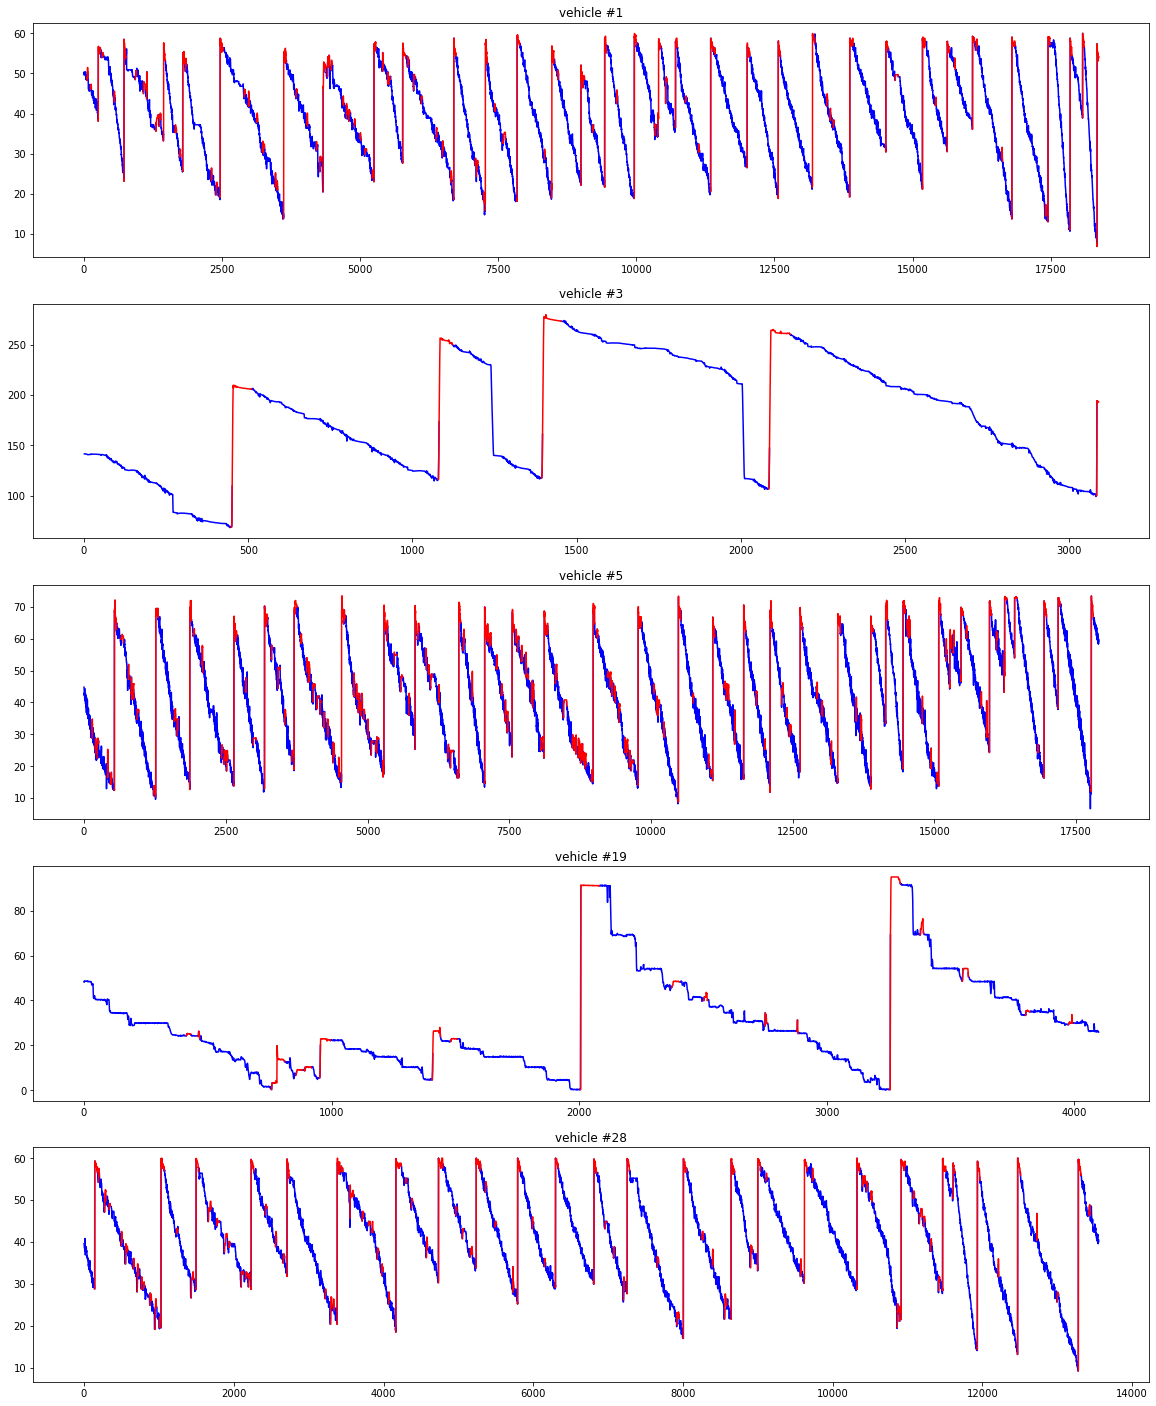

In [7]:
import matplotlib.pyplot as plt

nrows = len(VEHICLE_IDS)
fig, ax = plt.subplots(nrows, 1, figsize=(20, nrows*5))

for i, vehicle_id in enumerate(VEHICLE_IDS):
    
    dict_df = dict_df_vehicle_i(vehicle_id)
    df_sum = df_summary(dict_df, merge_how='inner')
    df_sum.drop(df_sum.loc[df_sum['fuellevel'] == 0].index, inplace=True)
    # я считаю, что можно все нули дропать
    # по крайней мере, для тех ТС, которые
    # нам даны

    # Если не сглаживать, некоторые заправки не детектятся
    orig = df_sum['fuellevel'].values
    smoothed = expSmoothing(df_sum['fuellevel'].values, alpha=0.9)

    growthIntervals, nonGrowthIntervals = findIntervals(smoothed, minGrowthAmount=0.5)

    for ngi in nonGrowthIntervals:
        ax[i].plot(range(ngi[0], ngi[1]+1), orig[ngi[0]:ngi[1]+1], c='b')

    for gi in growthIntervals:
        # сдвигаю левую границу на пару индксов влево, 
        # чтобы графики были красивые, т.к.
        # сглаживание сдвигает график вправо 
        # и интервалы роста получаются смещенными вправо
        # нужно будет дополнительно обрабатывать 
        # границы интервалов, но пока так
        ax[i].plot(range(gi[0]-2, gi[1]+1), orig[gi[0]-2:gi[1]+1], c='r')

    ax[i].set_title(f'vehicle #{vehicle_id}')